# **Prediction of First Hour Sales Surge**

# **Data Loading and Preprocessing**

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE

# Load the data
df = pd.read_excel("strategically_balanced_dataset.xlsx")

In [27]:
df.head(5)

,asin,title,category,brand,price,rating,reviews,is_prime,is_amazon_choice,url,hourly_sales,cart_adds,velocity_score,surge,price_sensitivity,age_tier,scraped_at,run_id,price_category
0,B09MM4FPMR,Lenovo IdeaPad Slim 3 Intel Celeron N4020 14''...,laptops,Lenovo,29999,4.0,887,False,False,https://www.amazon.in/Lenovo-IdeaPad-Celeron-P...,50,3548,1.000,1,0.900,established,2025-06-28 03:09:10,1,Premium
1,B0C8P8G3WJ,Acer Aspire Lite 11th Gen Intel Core i3 Premiu...,laptops,Acer,30890,4.0,818,True,False,https://www.amazon.in/Acer-Premium-Windows-AL1...,160,7828,1.000,1,0.897,established,2025-06-28 03:09:10,1,Premium
2,B09KBC64HS,"ASUS Vivobook 15, Intel Core i3-1215U, 16GB RA...",laptops,ASUS,35600,4.0,726,False,False,https://www.amazon.in/ASUS-Vivobook-1920x1080-...,41,2904,1.000,1,0.881,established,2025-06-28 03:09:10,1,Premium
3,B0BTTBFSHG,Acer Swift Go 14 Thin and Light Premium Laptop...,laptops,Acer,47999,4.3,13,True,False,https://www.amazon.in/Acer-SmartChoice-Hexa-Co...,0,39,0.091,0,0.840,new,2025-06-28 03:09:10,1,Premium
4,B0CJLP39RS,"Lenovo IdeaPad 1 AMD Ryzen 3 7320U 15.6"" HD Th...",laptops,Lenovo,30990,4.0,644,True,False,https://www.amazon.in/Lenovo-IdeaPad-Windows-W...,126,6163,1.000,1,0.897,established,2025-06-28 03:09:10,1,Premium


In [ ]:
df.tail(5)

,asin,title,category,brand,price,rating,reviews,is_prime,is_amazon_choice,url,hourly_sales,cart_adds,velocity_score,surge,price_sensitivity,age_tier,scraped_at,run_id,price_category
4995,B08VJ7H7M6,"5 Ace HD Groot Laptop Skin, for 10 to17inch fo...",laptops,Ace,279,0.0,0,False,False,https://www.amazon.in/Ace-Laptop-to17inch-Leno...,0,16,0.0373,0,0.999,new,2025-06-29 06:38:07,2,Budget
4996,B08VJ7GJXR,"5 Ace HD Iron Man T Laptop Skin, for 10 to17in...",laptops,Ace,279,0.0,0,False,False,https://www.amazon.in/Ace-Laptop-to17inch-Leno...,0,16,0.0373,0,0.999,new,2025-06-29 06:38:07,2,Budget
4997,B08VJ7CV33,"5 Ace HD neon Iron Man k Laptop Skin, for 10 t...",laptops,Ace,279,0.0,0,False,False,https://www.amazon.in/Ace-Laptop-to17inch-Leno...,0,16,0.0373,0,0.999,new,2025-06-29 06:38:07,2,Budget
4998,B08VJ7BWJF,"5 Ace HD Groot Laptop Skin, for 10 to17inch fo...",laptops,Ace,279,0.0,0,False,False,https://www.amazon.in/Ace-Laptop-to17inch-Leno...,0,16,0.0373,0,0.999,new,2025-06-29 06:38:07,2,Budget
4999,B08VJ7BNGZ,"5 Ace HD Thor Laptop Skin, for 10 to17inch for...",laptops,Ace,279,0.0,0,False,False,https://www.amazon.in/Ace-Laptop-to17inch-Leno...,0,16,0.0373,0,0.999,new,2025-06-29 06:38:07,2,Budget


# **Data Cleaning and Encoding**

In [28]:
# Drop leaky, redundant, and ID columns
drop_cols = ["asin", "title", "url", "cart_adds", "velocity_score",
             "price_sensitivity", "scraped_at", "run_id"]
df.drop(columns=drop_cols, inplace=True)

In [29]:
# Impute missing values in categorical data
imputer = SimpleImputer(strategy="most_frequent")
df["price_category"] = imputer.fit_transform(df[["price_category"]]).ravel()

In [30]:
# Encode categorical and boolean features
categorical_cols = df.select_dtypes(include=["object", "bool"]).columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

In [31]:
# Add noise to price and rating
df["price"] += np.random.normal(0, 2, df.shape[0])
df["rating"] += np.random.normal(0, 0.1, df.shape[0])
df["rating"] = df["rating"].clip(0, 5)

# Simulate label noise (2%)
flip_idx = df.sample(frac=0.02, random_state=42).index
df.loc[flip_idx, "surge"] = 1 - df.loc[flip_idx, "surge"]

In [32]:
# Separate features and target
X = df.drop(columns=["surge"])
y = df["surge"]

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)

# **Data Visualization**

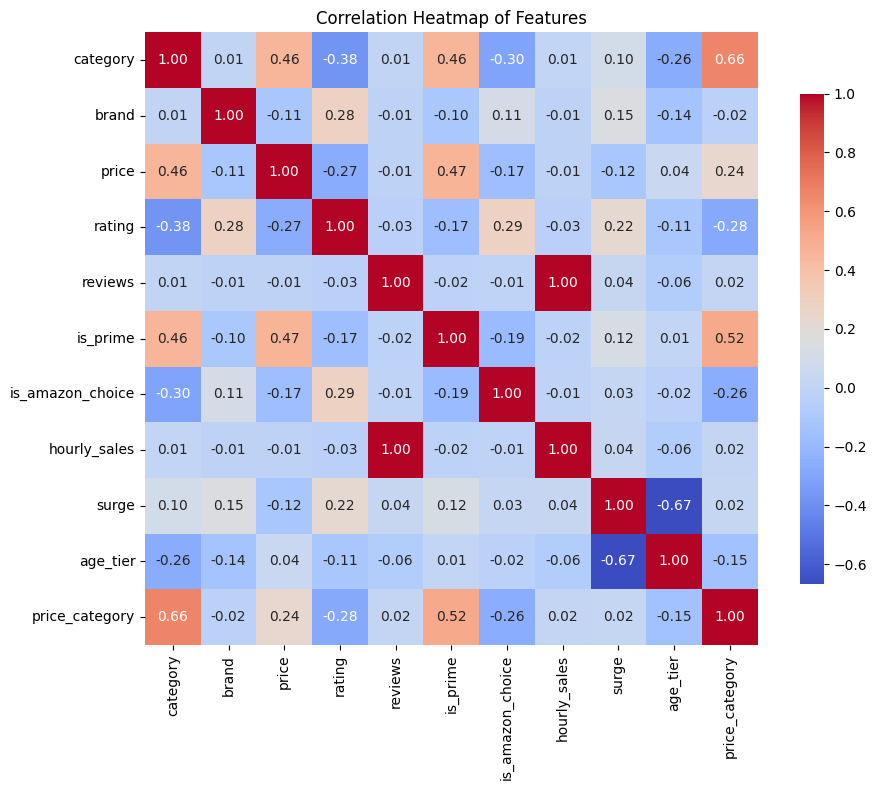

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Display correlation heatmap
plt.figure(figsize=(10, 8))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True, cbar_kws={"shrink": .8})
plt.title("Correlation Heatmap of Features")
plt.tight_layout()
plt.show()

/tmp/ipython-input-20-1522055279.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="surge", data=df, palette="pastel")


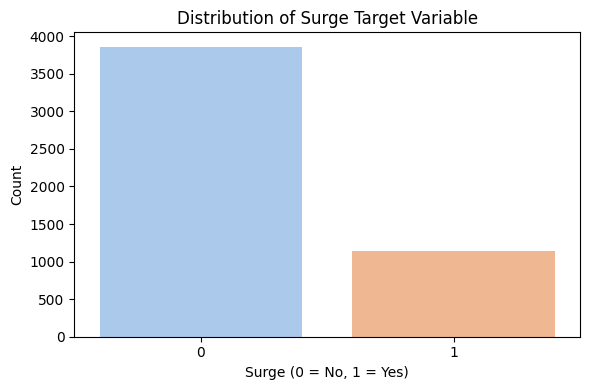

In [ ]:
# Count plot for target variable (surge)
plt.figure(figsize=(6, 4))
sns.countplot(x="surge", data=df, palette="pastel")
plt.title("Distribution of Surge Target Variable")
plt.xlabel("Surge (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

/tmp/ipython-input-21-1628370784.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="surge", y="price", data=df, palette="Set2")


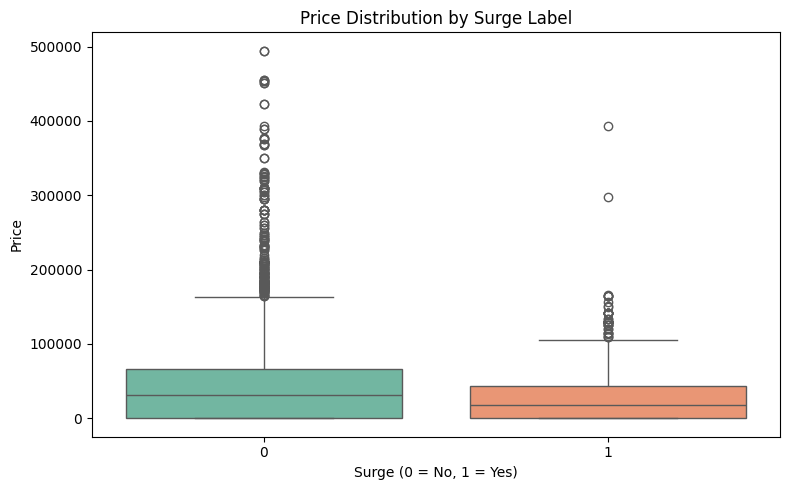

In [ ]:
# Boxplot for price vs surge
plt.figure(figsize=(8, 5))
sns.boxplot(x="surge", y="price", data=df, palette="Set2")
plt.title("Price Distribution by Surge Label")
plt.xlabel("Surge (0 = No, 1 = Yes)")
plt.ylabel("Price")
plt.tight_layout()
plt.show()

/tmp/ipython-input-22-3587977571.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="brand", y="rating", data=df[df["brand"].isin(top_brands)], ci=None, palette="muted")
/tmp/ipython-input-22-3587977571.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="brand", y="rating", data=df[df["brand"].isin(top_brands)], ci=None, palette="muted")


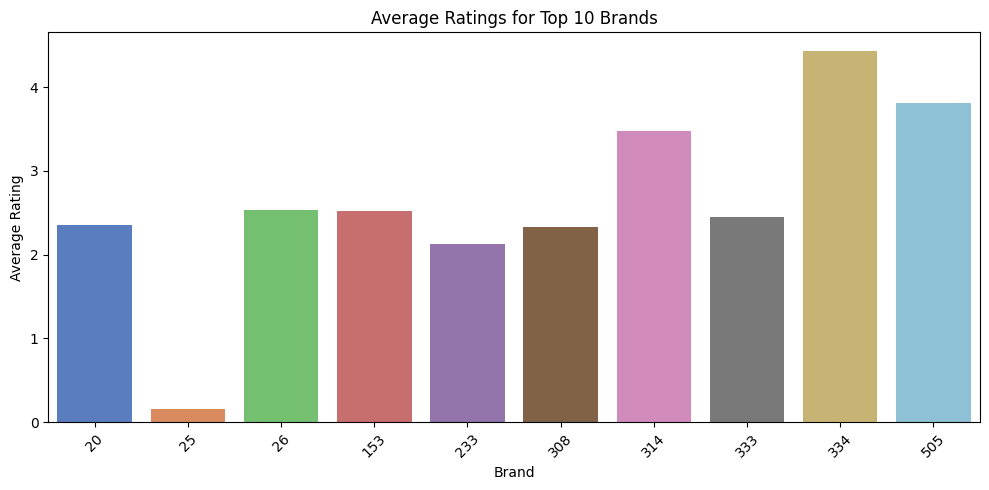

In [ ]:
# Barplot of average ratings per brand (top 10 brands by frequency)
top_brands = df["brand"].value_counts().nlargest(10).index
plt.figure(figsize=(10, 5))
sns.barplot(x="brand", y="rating", data=df[df["brand"].isin(top_brands)], ci=None, palette="muted")
plt.title("Average Ratings for Top 10 Brands")
plt.xticks(rotation=45)
plt.ylabel("Average Rating")
plt.xlabel("Brand")
plt.tight_layout()
plt.show()

# **Evaluate Models**

In [33]:
# Define models to compare
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "SVM": SVC(probability=True),
    "Naive Bayes": GaussianNB(),
    "XGBoost": XGBClassifier(eval_metric='logloss')
}

results = {}

# Train and evaluate each model
for name, clf in models.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1]

    report = classification_report(y_test, y_pred, output_dict=True)
    confusion = confusion_matrix(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    results[name] = {
        "Accuracy": np.round(report["accuracy"], 4),
        "Precision": np.round(report["1"]["precision"], 4),
        "Recall": np.round(report["1"]["recall"], 4),
        "F1-score": np.round(report["1"]["f1-score"], 4),
        "ROC-AUC": np.round(roc_auc, 4),
        "Confusion Matrix": confusion
    }

# Display results
for model_name, metrics in results.items():
    print(f"\n📌 Model: {model_name}")
    print(f"Accuracy: {metrics['Accuracy']}")
    print(f"Precision (1): {metrics['Precision']}")
    print(f"Recall (1): {metrics['Recall']}")
    print(f"F1-score (1): {metrics['F1-score']}")
    print(f"ROC-AUC: {metrics['ROC-AUC']}")
    print("Confusion Matrix:")
    print(metrics["Confusion Matrix"])

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



📌 Model: Random Forest
Accuracy: 0.956
Precision (1): 0.9764
Recall (1): 0.9324
F1-score (1): 0.9539
ROC-AUC: 0.9779
Confusion Matrix:
[[773  17]
 [ 51 703]]

📌 Model: Logistic Regression
Accuracy: 0.862
Precision (1): 0.9019
Recall (1): 0.805
F1-score (1): 0.8507
ROC-AUC: 0.9152
Confusion Matrix:
[[724  66]
 [147 607]]

📌 Model: SVM
Accuracy: 0.5311
Precision (1): 0.5111
Recall (1): 0.9191
F1-score (1): 0.6569
ROC-AUC: 0.5307
Confusion Matrix:
[[127 663]
 [ 61 693]]

📌 Model: Naive Bayes
Accuracy: 0.5298
Precision (1): 1.0
Recall (1): 0.0371
F1-score (1): 0.0716
ROC-AUC: 0.6389
Confusion Matrix:
[[790   0]
 [726  28]]

📌 Model: XGBoost
Accuracy: 0.9527
Precision (1): 0.971
Recall (1): 0.931
F1-score (1): 0.9506
ROC-AUC: 0.9734
Confusion Matrix:
[[769  21]
 [ 52 702]]


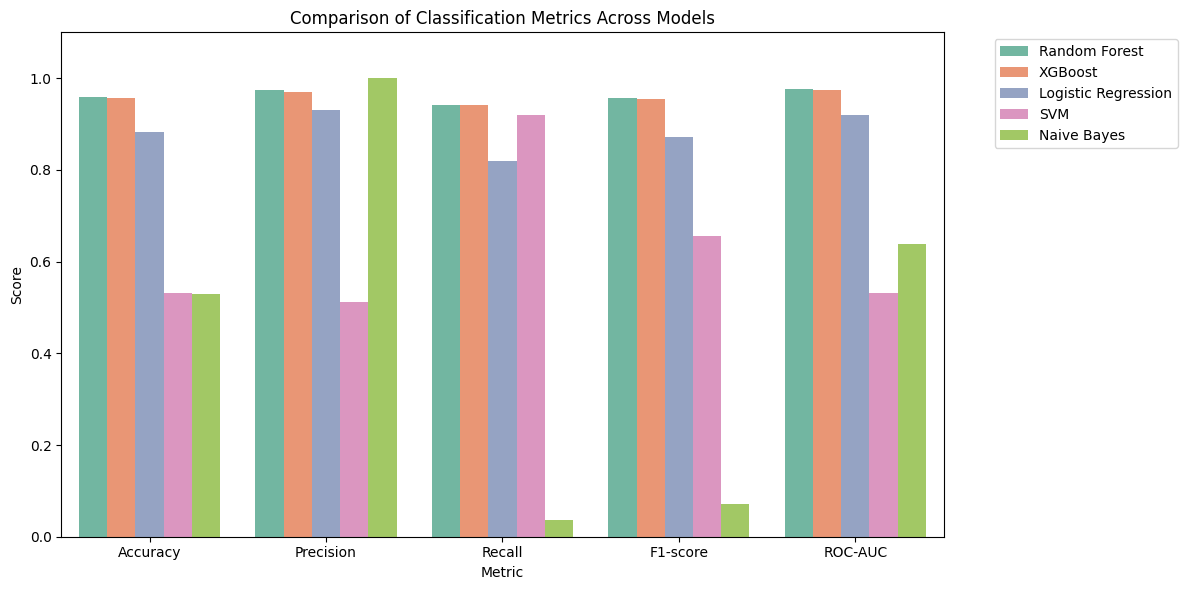

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define metric values
metrics_data = {
    "Classifier": ["Random Forest", "XGBoost", "Logistic Regression", "SVM", "Naive Bayes"],
    "Accuracy": [0.9592, 0.9573, 0.8821, 0.5311, 0.5298],
    "Precision": [0.9739, 0.9699, 0.9307, 0.5111, 1.0000],
    "Recall": [0.9416, 0.9416, 0.8196, 0.9191, 0.0371],
    "F1-score": [0.9575, 0.9556, 0.8717, 0.6569, 0.0716],
    "ROC-AUC": [0.9774, 0.9752, 0.9196, 0.5306, 0.6392]
}

# Create DataFrame
df_metrics = pd.DataFrame(metrics_data)

# Melt for plotting
df_melted = df_metrics.melt(id_vars="Classifier", var_name="Metric", value_name="Score")

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df_melted, x="Metric", y="Score", hue="Classifier", palette="Set2")
plt.title("Comparison of Classification Metrics Across Models")
plt.ylim(0, 1.1)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# **Feature Importance**

/tmp/ipython-input-24-3415162899.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values[:10], y=importances.index[:10], palette="viridis")


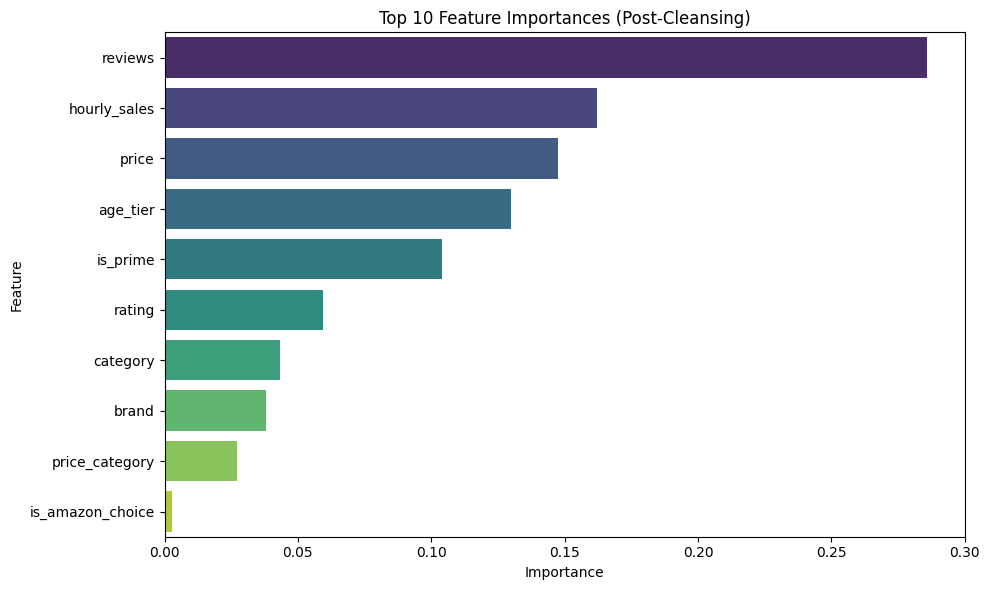

In [ ]:
# Feature importance (Random Forest)
rf_model = models["Random Forest"]
importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=importances.values[:10], y=importances.index[:10], palette="viridis")
plt.title("Top 10 Feature Importances (Post-Cleansing)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter tuning using GridSearchCV for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring='f1',
    verbose=1
)

grid_search.fit(X_train, y_train)

# Best parameters and evaluation
print("Best Parameters:\n", grid_search.best_params_)
best_rf = grid_search.best_estimator_

y_pred_best = best_rf.predict(X_test)
y_proba_best = best_rf.predict_proba(X_test)[:, 1]

print("\nClassification Report (Tuned Random Forest):")
print(classification_report(y_test, y_pred_best))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_best))

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Best Parameters:
 {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}

Classification Report (Tuned Random Forest):
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       790
           1       0.97      0.94      0.96       754

    accuracy                           0.96      1544
   macro avg       0.96      0.96      0.96      1544
weighted avg       0.96      0.96      0.96      1544

ROC-AUC: 0.9775333243796798
